In [53]:
import numpy as np
import matplotlib.pyplot as plt
import bqplot.pyplot as bqplt
import matplotlib as mpl
#mpl.style.use('default')
#These are some matplot lib configurations that I like to use. 
#mpl.rc("text", usetex=True) #if tou have Latex set this to true and matplotlib will render labels in latex
mpl.rc("font", family = "serif") #Serif font in matplotlib
mpl.rc("figure",figsize=(9,6)) #Increase default figure size
%config InlineBackend.figure_format = 'retina' #If you have a high res display, render the plots more nicely
mpl.style.use('dark_background') #Use a dark background for matplotlib figures if youre using dark theme
plt.rcParams.update({"figure.facecolor": "111111",
                     "savefig.facecolor": "212121"})

In [2]:
import geopandas as gpd
import pandas as pd

In [3]:
covid = pd.read_csv('data/Hospitalization_all_locs.csv')

In [4]:
states = gpd.read_file('data/cb_2018_us_state_500k.shp')
#states = states.to_crs('USA_Contiguous_Albers_Equal_Area_Conic')
states = states.astype({'STATEFP': 'int64', 'GEOID':'int64'})
states = states.loc[states['STATEFP'] < 60] #Not states
states = states.loc[states['STATEFP'] != 2] #bye alaska
states = states.loc[states['STATEFP'] != 15] #bye hawaii
# #states = states.assign(sind=lambda df: df.index.astype(str))

In [5]:
state_pop = pd.read_excel('data/nst-est2019-01.xlsx', header=1).dropna(0)
state_pop["Region"] = state_pop['Region'].str.strip('.')
state_pop = state_pop.rename(columns={'Region':'NAME', 2019:'pop2019'})
state_pop = state_pop[['NAME', 'pop2019']]

In [6]:
minimal = states[['GEOID', 'NAME', 'STUSPS', 'geometry']]
minimal = minimal.merge(state_pop, on='NAME')

In [7]:
l = []
for i,s in enumerate(states['NAME']):
    sdata = covid.loc[covid['location_name']==s]
    dtdates = pd.to_datetime(sdata['date'])
    sdata = sdata.loc[dtdates>pd.to_datetime('2020-02')]
    dtdates = pd.to_datetime(sdata['date'])
    dates = list(sdata['date'].values)
    td_mean = list(sdata['totdea_mean'].values)
    td_lower = list(sdata['totdea_lower'].values)
    td_upper = list(sdata['totdea_upper'].values)
    td_todate = td_mean[np.argmin(np.abs(dtdates-pd.to_datetime('2020-04-12')))]
    td_proj = td_mean[-1]
    l.append((s,  td_todate, td_proj, dtdates.values, td_mean, td_lower, td_upper))

In [8]:
state_covid = pd.DataFrame(data = l,columns=['NAME', 'td_todate', 'td_proj','dates','td_mean', 'td_lower', 'td_upper'])

In [9]:
minimal = minimal.merge(state_covid,on='NAME')

In [10]:
minimal = minimal.assign(td_per10k_now=lambda df: 1e4*df['td_todate']/df['pop2019'] )
minimal = minimal.assign(td_per10k_proj=lambda df: 1e4*df['td_proj']/df['pop2019'] )
minimal = minimal.assign(td_tocome=lambda df: (df['td_per10k_proj'] - df['td_per10k_now'])/df['td_per10k_proj'] )

In [11]:
from ipywidgets import Dropdown, link
from bqplot import Lines, Figure, LinearScale, DateScale, Axis
from ipyleaflet import Map, GeoData, WidgetControl, basemaps, LayersControl, Choropleth, GeoJSON
from branca.colormap import linear
import json

In [12]:
from ipywidgets import Text, HTML
from ipyleaflet import WidgetControl

In [13]:
def gdf_to_geojson_madness(gdf,jfname, idkey):
    gdf.to_file(jfname, driver='GeoJSON')

    with open(jfname,'r') as f:
        geojson = json.load(f)

    for f in geojson['features']:
        f['id'] = f['properties'][idkey]
    return geojson

In [14]:
!rm data/covid_state_data.geojson

rm: data/covid_state_data.geojson: No such file or directory


In [15]:
json_covid_states = gdf_to_geojson_madness(minimal[['GEOID', 'NAME', 'STUSPS', 'geometry', 'pop2019', 'td_todate',
       'td_proj', 'td_per10k_now','td_per10k_proj','td_tocome']],'data/covid_state_data.geojson','STUSPS')

In [16]:
geoj = GeoJSON(data = json_covid_states,style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.0},
                   hover_style={'fillColor': 'black' , 'fillOpacity': 0.1},
                   name = 'States')

In [17]:
color_by = 'td_tocome'
layer = Choropleth(
    geo_data=json_covid_states,
    choro_data=dict(zip(minimal['STUSPS'].values, minimal[color_by].values)),
    colormap=linear.YlGnBu_04,
    border_color='black',
    style={'fillOpacity': 0.8, 'dashArray': '5, 5'})

In [18]:
x_scale = LinearScale()
state_name = 'Massachusetts'
init = minimal.loc[minimal['NAME']==state_name]
dates = init['dates'].values[0]
date_scale = DateScale(min=dates[0], max=dates[-1])

mean = Lines(x=dates, y=init['td_mean'].values[0], scales={'x': date_scale, 'y': x_scale})
upper = Lines(x=dates, y=init['td_upper'].values[0], line_style='dashed', scales={'x': date_scale, 'y': x_scale})
lower = Lines(x=dates, y=init['td_lower'].values[0],  line_style='dashed', scales={'x': date_scale, 'y': x_scale})
ax_x = Axis(label='Time', scale=date_scale, num_ticks=10)
ax_y = Axis(label="Total Deaths", scale=x_scale, orientation='vertical', side='left')

figure = Figure(axes=[ax_x, ax_y], title=state_name+' Projections', marks=[mean, upper, lower], animation_duration=500,
                layout={'max_height': '500px', 'max_width': '800px'})

In [19]:
html = HTML('''Hover over a state''')
html.layout.margin = '0px 20px 20px 20px'
control = WidgetControl(widget=html, position='topright')
def update_html(feature, **kwargs):
    html.value = '''
        <h4>State Covid19 Deaths</h4>
        <h4><b>{}</b></h4>
        <h4>{} as of 4/12/20</h4>
        <h4>{} projected on 8/1/20</h4>
        <h4>{} Fraction yet to come</h4>
    '''.format(feature['properties']['NAME'], 
               np.round(feature['properties']['td_per10k_now'],decimals=4), 
               np.round(feature['properties']['td_per10k_proj'],decimals=4),
               np.round(feature['properties']['td_tocome'],decimals=4)
              )
    
def update_plot(event, feature, **kwargs):
    #print('here')
    global state_name
    state_name = feature['properties']['NAME']
    update_figure(state_name)

geoj.on_hover(update_html)
geoj.on_click(update_plot)

In [20]:
def update_figure(state):
    #print('here')
    mean.y = minimal.loc[minimal['NAME'] == state]['td_mean'].values[0]
    upper.y = minimal.loc[minimal['NAME'] == state]['td_upper'].values[0]
    lower.y = minimal.loc[minimal['NAME'] == state]['td_lower'].values[0]
    #ax_y.label = data_name.capitalize()
    figure.title = state+ ' Projections'

# Some maps showing the deadliness of COVID19 in the Continental US



In [47]:
#m = Map(basemap=basemaps.CartoDB.DarkMatter, center=[38,-90], zoom=4)
m = Map(basemap=basemaps.CartoDB.DarkMatter, center=[38,-90], zoom=4)
m.add_layer(layer)
m.add_layer(geoj)
m.add_control(control)

### Here states are colored by their current per capita death rates.

You can mouseover the states to see their current rates (updated 4/12/20) and the projections from the IHME for August 1, 2020. Rates are given in deaths per $10^4$ people. Unforuntely I havent been able to display a colorbar yet but blue corresponds to higher values and yellow to lower ones. Wyoming currently has 0 so and New York has the most for reference.

If you click on a state, its IHME data will appear on the plot below. The solid line is the model average and the dashed lines indiciate the upper and lower bounds from the model.

In [48]:
color_by2 = 'td_per10k_now'
layer2 = Choropleth(
    geo_data=json_covid_states,
    choro_data=dict(zip(minimal['STUSPS'].values, minimal[color_by2].values)),
    colormap=linear.YlGnBu_04,
    border_color='black',
    style={'fillOpacity': 0.8, 'dashArray': '5, 5'})

In [49]:
m2 = Map(basemap=basemaps.CartoDB.DarkMatter, center=[38,-90], zoom=4)
m2.add_layer(layer2)
m2.add_layer(geoj)
m2.add_control(control)

In [50]:
m2

Map(center=[38, -90], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

In [51]:
figure

Figure(animation_duration=500, axes=[Axis(label='Time', num_ticks=10, scale=DateScale(max=datetime.datetime(20…

### Here state are colored by the fraction of projected per captita deaths that have yet to occur.

It a little clunky but if you click here it will also update the graph above (hopefully I'll make this better soon).

In [52]:
m

Map(center=[38, -90], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

It took me a while to learn how to make this all interactive and available but I will try to add any other cool maps as I make them. Before I started making interactive ones I took a look at the correlation of COVID deaths and political affiliation. Turns out that the previous map, fraction of projected deaths yet to come looks a lot like the results of the 2016 election. Ill leave you with a couple scatter plots to show what I mean.

In [28]:
votes = pd.read_csv('data/state_2016_pres.csv')
votes = votes.loc[votes['year']==2016]
#votes = votes.loc[votes['party'].isin(['democrat', 'reublican'])]
votes = votes.loc[~votes['writein']]
votes = votes.rename(columns={'state_fips':'GEOID'})
votes = votes.loc[votes['GEOID'].isin(minimal['GEOID'].unique())]
dem = votes.loc[votes['party']=='democrat']
rep = votes.loc[votes['party']=='republican']
dem = dem[['state', 'GEOID', 'candidatevotes', 'totalvotes']]
dem = dem.rename(columns={'candidatevotes':'demvotes'})
rep = rep.rename(columns={'candidatevotes':'repvotes'})
split_votes = dem.merge(rep[['state','repvotes']], on='state')

In [29]:
split_votes = split_votes.assign(dfrac=lambda df: df['demvotes']/df['totalvotes'])
split_votes = split_votes.assign(rfrac=lambda df: df['repvotes']/df['totalvotes'])

In [30]:
minimal = minimal.merge(split_votes[['GEOID', 'demvotes', 'totalvotes', 'repvotes', 'dfrac',
       'rfrac']], on='GEOID')

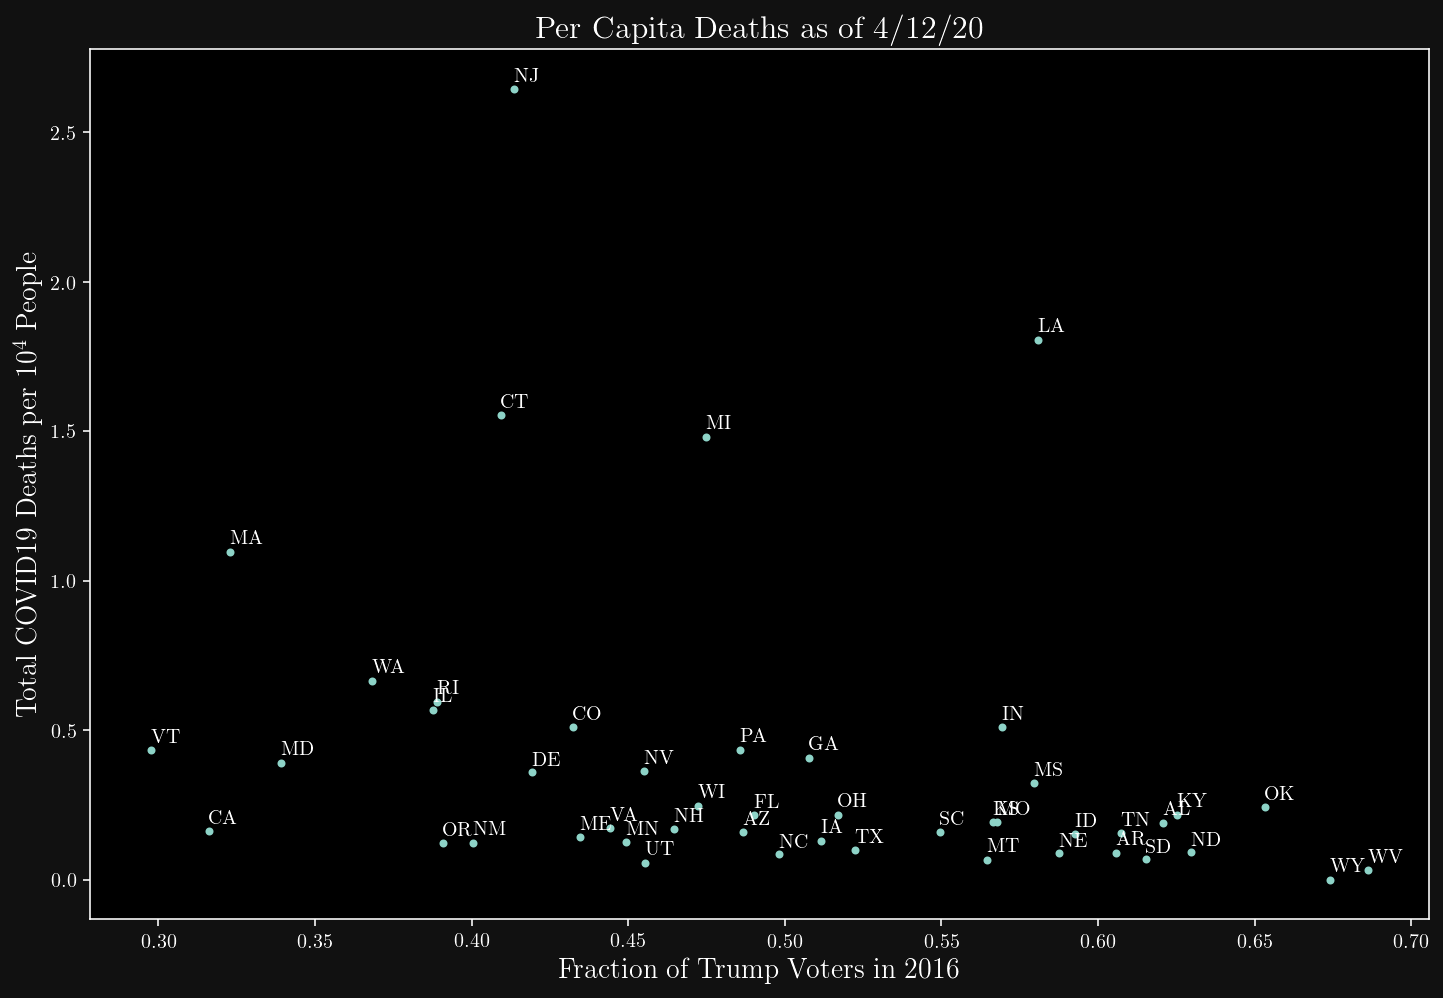

In [44]:
tmp = minimal.loc[~minimal['STUSPS'].isin(['NY','DC'])]
tmp = tmp.reset_index()
plt.figure(figsize=(12,8))
plt.scatter(tmp['rfrac'], tmp['td_per10k_now'], marker='.')
ax = plt.gca()
for i,t in enumerate(tmp['STUSPS']):
    ax.annotate(t, (tmp['rfrac'][i], tmp['td_per10k_now'][i]+0.025), fontsize=10)
ax.set_ylabel(r'Total COVID19 Deaths per $10^4$ People',fontsize=14)
ax.set_xlabel(r'Fraction of Trump Voters in 2016',fontsize=14)
plt.title("Per Capita Deaths as of 4/12/20",fontsize=16)
#plt.savefig('covid_vs_rfrac.png',dpi=500)
plt.show()

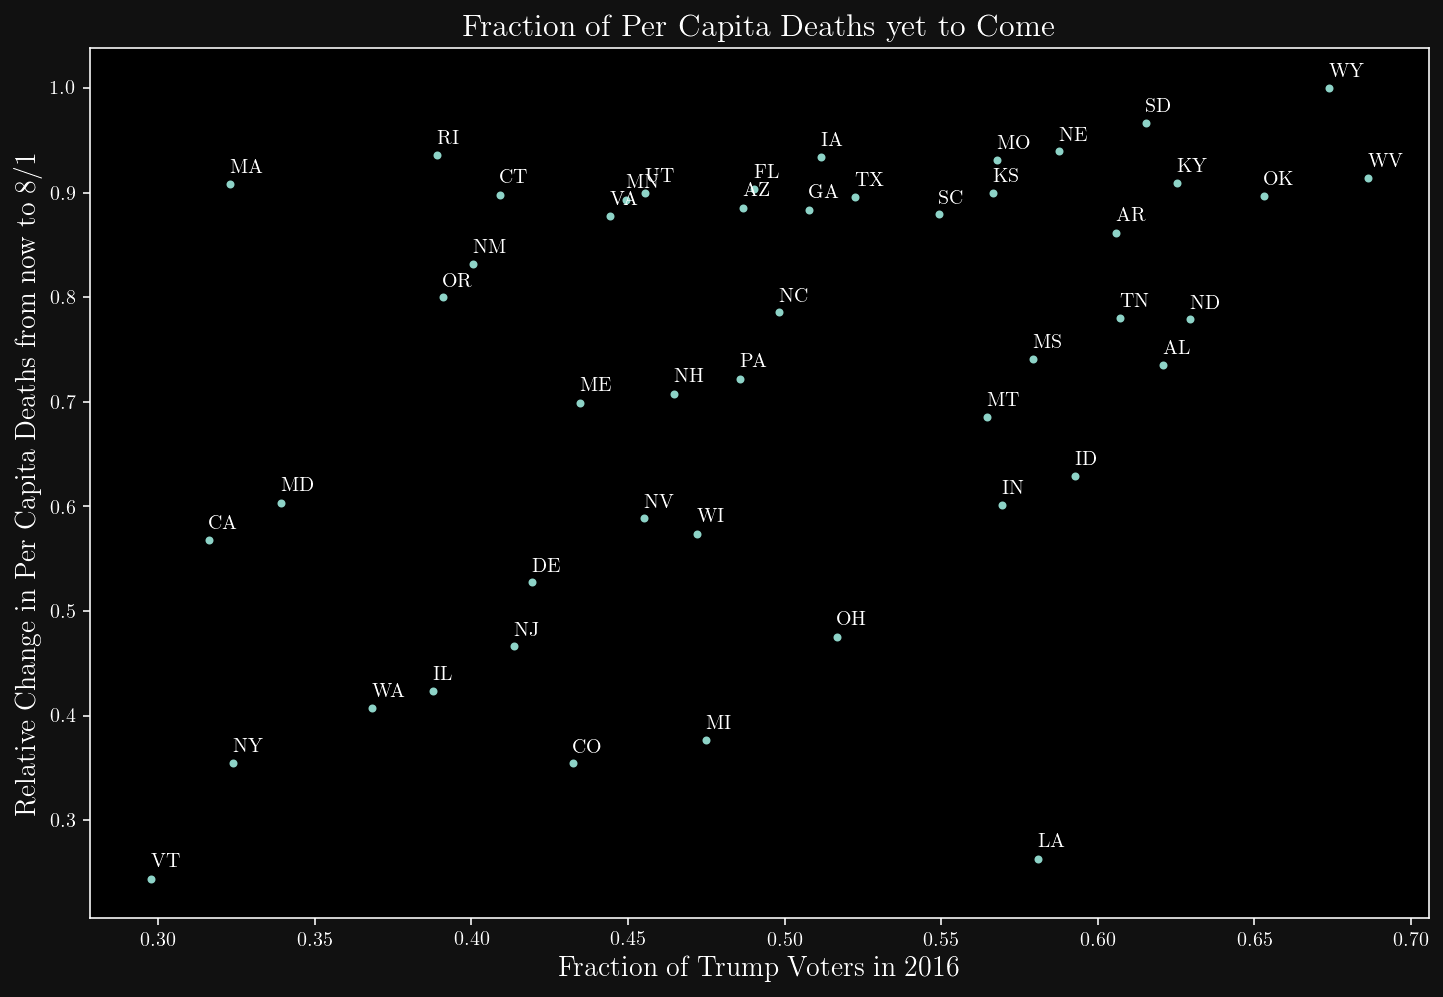

In [45]:
tmp = minimal.loc[~minimal['STUSPS'].isin(['DC'])]
tmp = tmp.reset_index()
plt.figure(figsize=(12,8))
plt.scatter(tmp['rfrac'], tmp['td_tocome'], marker='.')
ax = plt.gca()
for i,t in enumerate(tmp['STUSPS']):
    ax.annotate(t, (tmp['rfrac'][i], tmp['td_tocome'][i]+0.01), fontsize=10)
ax.set_xlabel(r'Fraction of Trump Voters in 2016',fontsize=14)
ax.set_ylabel(r'Relative Change in Per Capita Deaths from now to 8/1',fontsize=14)
plt.title("Fraction of Per Capita Deaths yet to Come",fontsize=16)
#plt.savefig('delta_pcd_vs_rfrac.png',dpi=500)
plt.show()

If you want to see the jupyter notebook that generated this its available [on my github](https://github.com/jrussell25/cartography/blob/master/covid_map.ipynb).